In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from oemof.solph import Bus, Flow, EnergySystem, Model, processing, views
from oemof.solph.components import GenericStorage, Sink, Source, Transformer
import numpy as np
from pandas.tseries.offsets import Hour
%matplotlib inline

In [2]:
#make time index for our data
datetimeindex = pd.date_range( '2021-11-25 8:00:00', periods=752, freq='H') # 2021-11-25 44928 '1/1/2016' 2021-11-25
datetimeindex

DatetimeIndex(['2021-11-25 08:00:00', '2021-11-25 09:00:00',
               '2021-11-25 10:00:00', '2021-11-25 11:00:00',
               '2021-11-25 12:00:00', '2021-11-25 13:00:00',
               '2021-11-25 14:00:00', '2021-11-25 15:00:00',
               '2021-11-25 16:00:00', '2021-11-25 17:00:00',
               ...
               '2021-12-26 06:00:00', '2021-12-26 07:00:00',
               '2021-12-26 08:00:00', '2021-12-26 09:00:00',
               '2021-12-26 10:00:00', '2021-12-26 11:00:00',
               '2021-12-26 12:00:00', '2021-12-26 13:00:00',
               '2021-12-26 14:00:00', '2021-12-26 15:00:00'],
              dtype='datetime64[ns]', length=752, freq='H')

In [3]:
#initializing an instance of the energy system,
setting the time index as the datetime index, and enabling the option
energysystem = EnergySystem(timeindex=datetimeindex, infer_last_interval=True)

In [4]:
filename = 'haiti data - dataset (1).csv'
data = pd.read_csv(filename)
data.head()

,date,date_time,time,month,day,hour,P_1,pv,pv factor
0,11/25/2021,11/25/21 08:00:00,8:00:00 AM,11,25,8,164.80,0,0
1,11/25/2021,11/25/21 09:00:00,9:00:00 AM,11,25,9,163.95,0,0
2,11/25/2021,11/25/21 10:00:00,10:00:00 AM,11,25,10,150.49,0,0
3,11/25/2021,11/25/21 11:00:00,11:00:00 AM,11,25,11,195.37,80,16
4,11/25/2021,11/25/21 12:00:00,12:00:00 PM,11,25,12,303.59,1025,205


In [5]:
data

,date,date_time,time,month,day,hour,P_1,pv,pv factor
0,11/25/2021,11/25/21 08:00:00,8:00:00 AM,11,25,8,164.80,0,0
1,11/25/2021,11/25/21 09:00:00,9:00:00 AM,11,25,9,163.95,0,0
2,11/25/2021,11/25/21 10:00:00,10:00:00 AM,11,25,10,150.49,0,0
3,11/25/2021,11/25/21 11:00:00,11:00:00 AM,11,25,11,195.37,80,16
4,11/25/2021,11/25/21 12:00:00,12:00:00 PM,11,25,12,303.59,1025,205
...,...,...,...,...,...,...,...,...,...
747,12/26/2021,12/26/21 11:00:00,11:00:00 AM,12,26,11,62.87,40,8
748,12/26/2021,12/26/21 12:00:00,12:00:00 PM,12,26,12,188.60,910,182
749,12/26/2021,12/26/21 13:00:00,1:00:00 PM,12,26,13,246.54,1910,382
750,12/26/2021,12/26/21 14:00:00,2:00:00 PM,12,26,14,280.43,2790,558


In [214]:
data.describe()

,month,day,hour,P_1,pv,pv factor
count,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000
mean,11.819149,15.925532,11.500000,128.469827,1112.546543,222.509309
std,0.385151,8.712896,6.893908,97.280781,1378.680692,275.736138
min,11.000000,1.000000,0.000000,13.940000,0.000000,0.000000
25%,12.000000,8.000000,6.000000,57.230000,0.000000,0.000000
50%,12.000000,16.000000,11.500000,103.210000,35.000000,7.000000
75%,12.000000,24.000000,17.000000,176.992500,2478.750000,495.750000
max,12.000000,30.000000,23.000000,940.360000,3790.000000,758.000000


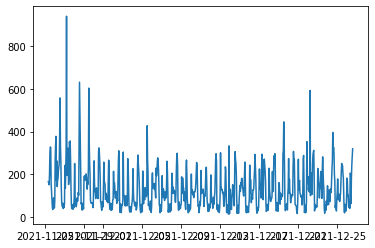

In [215]:
#consumption of electricity.
data.index = datetimeindex
plt.plot(data['P_1'])


In [216]:
# resource buses
bus_diesel = Bus(label='diesel')

In [217]:
# electricity and heat buses
bus_el = Bus(label='electricity')


In [218]:
#diesel variable costs
source_diesel = Source(label='source_diesel', outputs={bus_el: Flow(variable_costs=0.0001104)})   
#variable costs assumed to be diesel price in Haiti (EUR per Wh)

In [219]:
#generation of electricity by 5kw PV
pv = Source(label='pv', outputs={bus_el: Flow(fix=data['pv'],
                                              nominal_value=1)}) 
#nominal value = 1, as pv generation already transformed to 5kW size

In [220]:
#consumption of electricity
demand_el = Sink(label='P_1',
                 inputs={bus_el: Flow(nominal_value=1,
                                         fix=data['P_1'],
                                         )})

In [221]:
# diesel power plant
pp_diesel = Transformer(label='pp_diesel',
                      inputs={bus_diesel: Flow()},
                      outputs={bus_el: Flow(nominal_value=2000)},
                      conversion_factors={bus_el: 0.3}) 
#nominal value = 2kW, assuming small diesel lant of 2kW

In [222]:
#battery parametres
storage_el = GenericStorage(label='storage_el',
                            nominal_storage_capacity=41100,
                            inputs={bus_el: Flow(nominal_value=2850)},
                            outputs={bus_el: Flow(nominal_value=2850)},
                            loss_rate=0.01,
                            initial_storage_level=0,
                            max_storage_level=0.5,
                            inflow_conversion_factor=0.99,
                            outflow_conversion_factor=0.99)
#nominal value - limited by inverter
#max storage level - limited due to worn out battery

In [223]:
#excess and shortage variables
excess_el = Sink(label='excess_el', inputs={bus_el: Flow()})

shortage_el = Source(label='shortage_el',
                     outputs={bus_el: Flow(variable_costs=10000000)}) 
#variable costs should be as much as possible for system not to choose it

In [224]:
#creating energy system
energysystem.add(bus_diesel, bus_el,
                source_diesel,
                 pv, demand_el,
                 pp_diesel, storage_el,
                 excess_el, shortage_el)

In [225]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver='glpk')

{'Problem': [{'Name': 'unknown', 'Lower bound': 5.115009744, 'Upper bound': 5.115009744, 'Number of objectives': 1, 'Number of constraints': 3009, 'Number of variables': 6016, 'Number of nonzeros': 9776, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.10248064994812012}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [226]:
#calculating results
results_main = processing.results(optimization_model)
results_meta = processing.meta_results(optimization_model)
params = processing.parameter_as_dict(energysystem)

In [227]:
#showing results of otimization
results_meta 
#overall operational costs of system

{'objective': 5.115009743999999,
 'problem': {'Name': 'unknown',
  'Lower bound': 5.115009744,
  'Upper bound': 5.115009744,
  'Number of objectives': 1,
  'Number of constraints': 3009,
  'Number of variables': 6016,
  'Number of nonzeros': 9776,
  'Sense': <ProblemSense.minimize: 'minimize'>},
 'solver': {'Status': <SolverStatus.ok: 'ok'>,
  'Termination condition': <TerminationCondition.optimal: 'optimal'>,
  'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}},
  'Error rc': 0,
  'Time': 0.10248064994812012}}

In [228]:
#checking battery results
flows_el['Battery'] = results_main[storage_el,bus_el]['sequences']     
flows_el['Battery'].describe()

count     752.000000
mean      128.856383
std       592.539971
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2850.000000
Name: Battery, dtype: float64

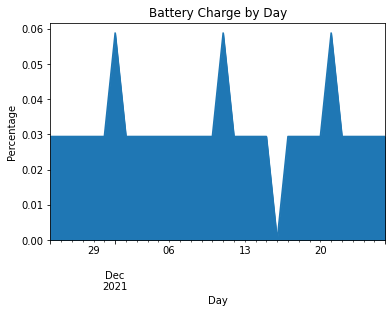

In [231]:
#Creating plot to show battery
flows_el['Battery'] = results_main[storage_el, bus_el]['sequences']

total_battery_charge = flows_el['Battery'].sum()

flows_el['Total Battery Charge'] = total_battery_charge

flows_el_percentage = pd.DataFrame(index=datetimeindex)
flows_el_percentage['Battery'] = flows_el['Battery'] / total_battery_charge

flows_el_percentage.resample('D').sum().plot.area(y='Battery', legend=False)
plt.xlabel('Day')
plt.ylabel('Percentage')
plt.title('Battery Charge by Day')
plt.show()

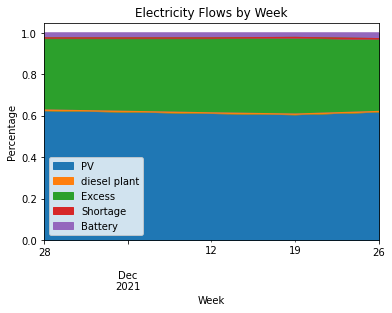

In [230]:
#Making otimal disatch for the whole period, showing all components: 
#PV, Excess,Shortage, Diesel, Battery 

# Create a DataFrame to store electricity flows
flows_el = pd.DataFrame(index=datetimeindex)
flows_el['PV'] = results_main[pv, bus_el]['sequences']
flows_el['diesel plant'] = results_main[pp_diesel, bus_el]['sequences']
flows_el['Excess'] = results_main[bus_el, excess_el]['sequences']
flows_el['Shortage'] = results_main[shortage_el, bus_el]['sequences']
flows_el['Total'] = flows_el['PV'] + flows_el['diesel plant'] + flows_el['Excess'] + flows_el['Shortage']

# Add battery flow
flows_el['Battery'] = results_main[storage_el, bus_el]['sequences'] 

# Creating a DataFrame for a percentage
flows_el_percentage = pd.DataFrame(index=datetimeindex)

# Calculate the percentage for each column
for column in flows_el.columns:
    if column != 'Total':
        flows_el_percentage[column] = flows_el[column] / flows_el['Total']

flows_el_percentage_normalized = flows_el_percentage.resample('W').sum().div(flows_el_percentage.resample('W').sum().sum(axis=1), axis=0)

# Plotting an area with a date scale by week
flows_el_percentage_normalized.plot(kind='area')

# Chart Setup
plt.xlabel('Week')
plt.ylabel('Percentage')
plt.title('Electricity Flows by Week')
plt.legend()

# Show graph
plt.show()


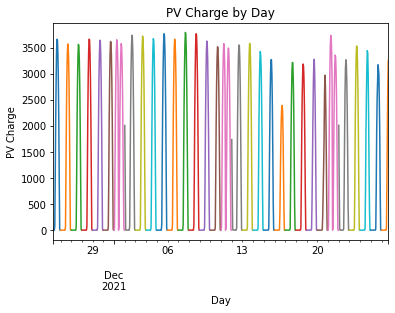

In [156]:
#Showing PV generation over whole period
flows_el['PV'] = results_main[pv, bus_el]['sequences']

# Create a new DataFrame for cumulative PV charge
flows_el_percentage = pd.DataFrame(index=datetimeindex)

# Calculate cumulative PV charge
flows_el_percentage['PV'] = flows_el['PV']

# Resample for weekly data and calculate the charge amount for each week
weekly_pv_charge = flows_el_percentage.resample('D')

# Plot cumulative PV charge over time for each week
weekly_pv_charge.plot.line(y='PV', legend=False)
plt.xlabel('Day')
plt.ylabel('PV Charge')
plt.title('PV Charge by Day')
plt.show()

<Figure size 720x432 with 0 Axes>

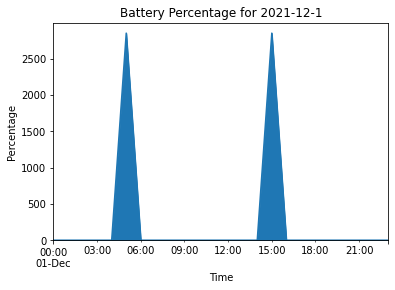

In [157]:
#Showing battery content for 1 chosen day

flows_el['Battery'] = results_main[storage_el, bus_el]['sequences']
flows_el['PV'] = results_main[pv, bus_el]['sequences']

total_battery_charge = flows_el['Battery'].sum()

flows_el_percentage = pd.DataFrame(index=flows_el.index)
flows_el_percentage['Battery'] = flows_el['Battery'] 

desired_date = '2021-12-1'
selected_date_data = flows_el_percentage[flows_el_percentage.index.date == pd.to_datetime(desired_date).date()]

plt.figure(figsize=(10, 6))
selected_date_data.plot.area(y='Battery', legend=False)
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.title(f'Battery Percentage for {desired_date}')
plt.show()

<Figure size 720x432 with 0 Axes>

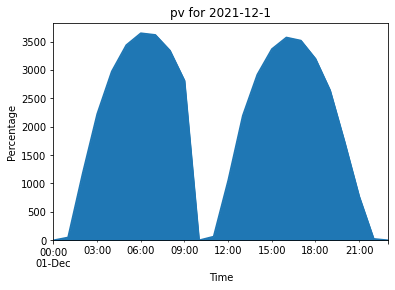

In [158]:
#Showing PV generation for same day

flows_el['PV'] = results_main[pv, bus_el]['sequences']

total_battery_charge = flows_el['PV'].sum()

flows_el_percentage = pd.DataFrame(index=flows_el.index)
flows_el_percentage['Battery'] = flows_el['PV'] 

desired_date = '2021-12-1'
selected_date_data = flows_el_percentage[flows_el_percentage.index.date == pd.to_datetime(desired_date).date()]

plt.figure(figsize=(10, 6))
selected_date_data.plot.area(y='Battery', legend=False)
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.title(f'pv for {desired_date}')
plt.show()

In [159]:
!pip install oemof.solph

In [160]:
from oemof.solph import Bus, Flow, EnergySystem, Model, processing, views, Investment
from oemof.solph.components import GenericStorage, Sink, Source, Transformer
import oemof.solph as solph
from oemof.tools import economics
%matplotlib inline

{'sequences':                      ((electricity, storage_el), flow)  \
2021-11-25 08:00:00                           0.000000   
2021-11-25 09:00:00                           0.000000   
2021-11-25 10:00:00                           0.000000   
2021-11-25 11:00:00                           0.000000   
2021-11-25 12:00:00                           0.000000   
...                                                ...   
2021-12-26 12:00:00                           0.000000   
2021-12-26 13:00:00                        1663.460000   
2021-12-26 14:00:00                        1290.413534   
2021-12-26 15:00:00                           0.000000   
2021-12-26 16:00:00                                NaN   

                     ((storage_el, None), storage_content)  \
2021-11-25 08:00:00                               0.000000   
2021-11-25 09:00:00                               0.000000   
2021-11-25 10:00:00                               0.000000   
2021-11-25 11:00:00                      

<Axes: >

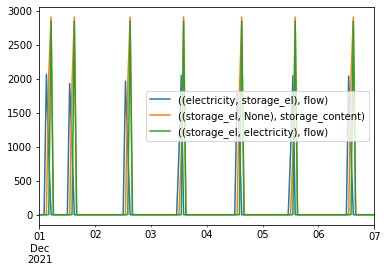

In [188]:
#Ploting battery charge/discharge/content for whole period

results_storage = solph.views.node(results_main, 'storage_el')
print(results_storage) 
# Extract timeseries data of flow 
desired_period = pd.date_range('2021-12-01', '2021-12-07', freq='60min')
results_storage_ts = results_storage['sequences']
selected_date_data = results_storage_ts[results_storage_ts.index.isin(desired_period)]


selected_date_data.plot()

{'sequences':                      ((pv, electricity), flow)
2021-11-25 08:00:00                        0.0
2021-11-25 09:00:00                        0.0
2021-11-25 10:00:00                        0.0
2021-11-25 11:00:00                       80.0
2021-11-25 12:00:00                     1025.0
...                                        ...
2021-12-26 12:00:00                      910.0
2021-12-26 13:00:00                     1910.0
2021-12-26 14:00:00                     2790.0
2021-12-26 15:00:00                     3255.0
2021-12-26 16:00:00                        NaN

[753 rows x 1 columns]}


<Axes: >

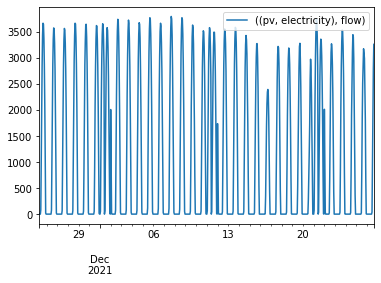

In [168]:
#Create optimization model 
# Extract results with processing module from model
results = solph.processing.results(optimization_model)
# Extract component results dict with used component labels
results_pv = solph.views.node(results, 'pv')
results_storage = solph.views.node(results, 'storage')
print(results_pv)
# Extract timeseries data of flow
results_pv_ts = results_pv['sequences']
results_pv_ts.plot()

{'sequences':                      ((electricity, storage_el), flow)  \
2021-11-25 08:00:00                           0.000000   
2021-11-25 09:00:00                           0.000000   
2021-11-25 10:00:00                           0.000000   
2021-11-25 11:00:00                           0.000000   
2021-11-25 12:00:00                           0.000000   
...                                                ...   
2021-12-26 12:00:00                           0.000000   
2021-12-26 13:00:00                        1663.460000   
2021-12-26 14:00:00                        1290.413534   
2021-12-26 15:00:00                           0.000000   
2021-12-26 16:00:00                                NaN   

                     ((storage_el, None), storage_content)  \
2021-11-25 08:00:00                               0.000000   
2021-11-25 09:00:00                               0.000000   
2021-11-25 10:00:00                               0.000000   
2021-11-25 11:00:00                      

<Axes: >

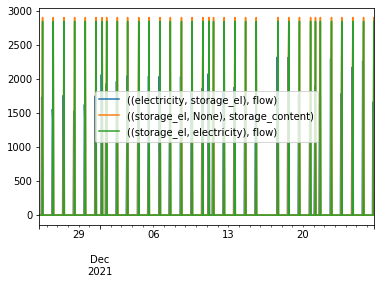

In [171]:
 # Extract results with processing module from model
results_storage = solph.views.node(results, 'storage_el')
print(results_storage) 
# Extract timeseries data of flow 
results_storage_ts = results_storage['sequences']
results_storage_ts.plot()

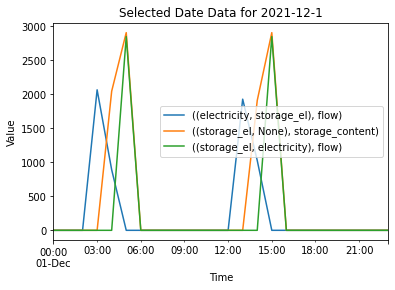

In [170]:
#Ploting battery charge/discharge/content for one chosen day

results_storage_ts = results_storage['sequences']
desired_date = '2021-12-1'
selected_date_data = results_storage_ts[results_storage_ts.index.date == pd.to_datetime(desired_date).date()]
selected_date_data.plot()

plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Selected Date Data for {desired_date}')
plt.show()

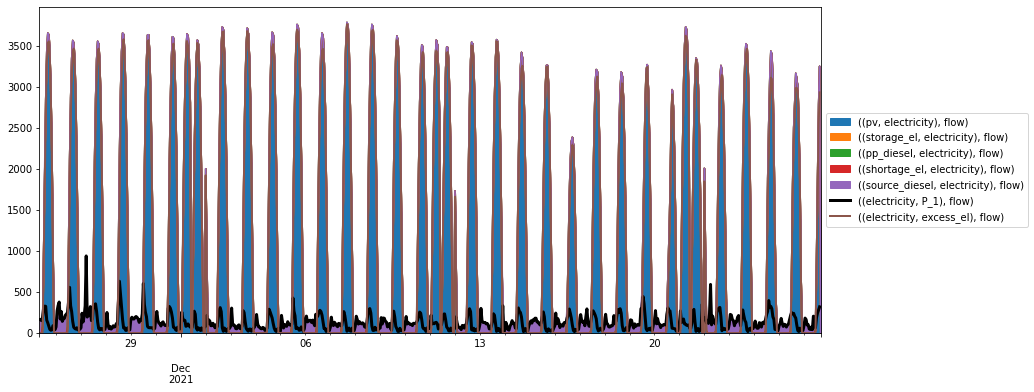

In [100]:
#Showing division for the whole period after optimization

results = processing.results(optimization_model)
results_el = views.node(results, 'electricity')
el_sequences = results_el['sequences']
to_el = {key[0][0]: key for key in el_sequences.keys() if key[0][1] == 'electricity' and key[1] == 'flow'}
to_el = [to_el.pop('pv'),  to_el.pop('storage_el')] + list(to_el.values())
el_prod = el_sequences[to_el]
fig, ax = plt.subplots(figsize=(14, 6))
el_prod.plot.area(ax=ax)
el_sequences[(('electricity','P_1'), 'flow')].plot(ax=ax, linewidth=3, c='k')
el_sequences[(('electricity','excess_el'), 'flow')].plot(ax=ax, linewidth=2)
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

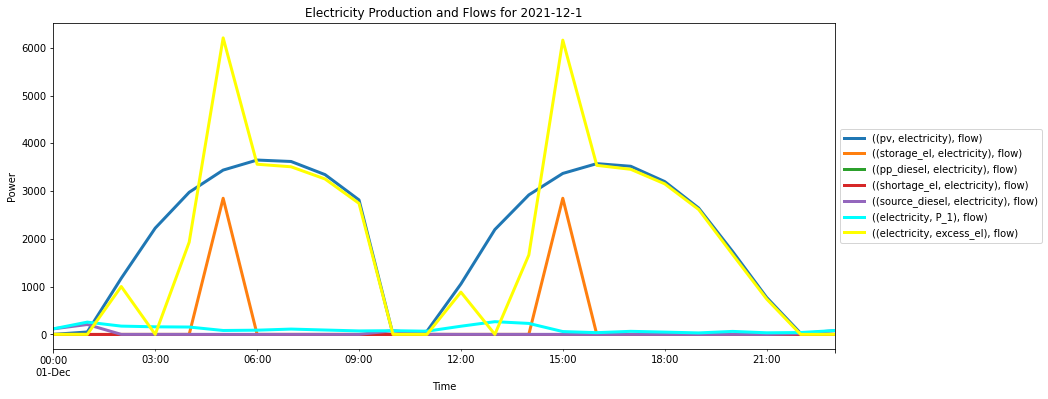

In [172]:
#Showing optimal disatch of our model for a chosen day

results_el = views.node(results, 'electricity')
el_sequences = results_el['sequences']
P1_el_s = el_sequences[(('electricity', 'P_1'), 'flow')]
Exces = el_sequences[(('electricity', 'excess_el'), 'flow')]

to_el = {key[0][0]: key for key in el_sequences.keys() if key[0][1] == 'electricity' and key[1] == 'flow'}
to_el = [to_el.pop('pv'), to_el.pop('storage_el')] + list(to_el.values())
el_prod = el_sequences[to_el]

desired_date = '2021-12-1'  # Replace this with your desired date
selected_date_data = el_prod[el_prod.index.date == pd.to_datetime(desired_date).date()]
selected_date_data_P1 = P1_el_s[P1_el_s.index.date == pd.to_datetime(desired_date).date()]
selected_date_data_E = Exces[Exces.index.date == pd.to_datetime(desired_date).date()]


fig, ax = plt.subplots(figsize=(14, 6))
selected_date_data.plot(ax=ax, linewidth=3)

selected_date_data_P1.plot(ax=ax, linewidth=3, c='cyan')
selected_date_data_E.plot(ax=ax, linewidth=3, color = 'yellow')

legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('Time')
ax.set_ylabel('Power')
ax.set_title(f'Electricity Production and Flows for {desired_date}')
plt.show()

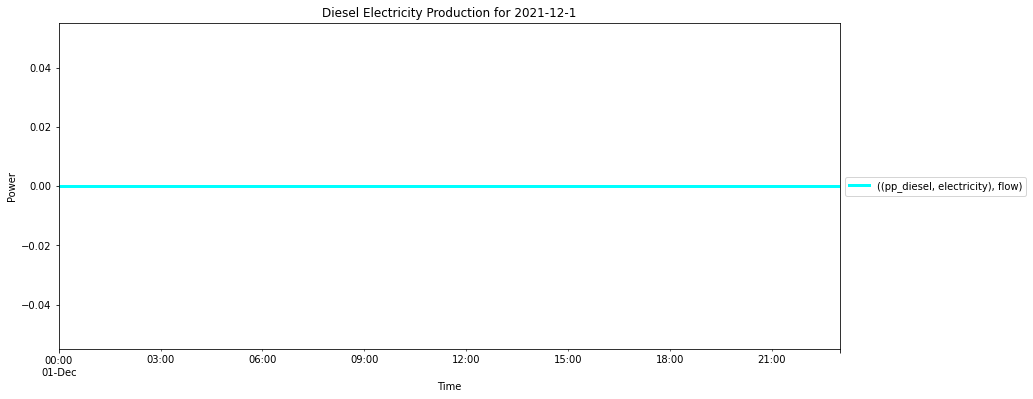

In [173]:
#Showing diesel generation part

results_el = views.node(results, 'electricity')
el_sequences = results_el['sequences']

#desired_date = '2021-12-1'  # Replace this with your desired date
desired_flow_key = (('pp_diesel', 'electricity'), 'flow')

selected_date_data = el_sequences[desired_flow_key][el_sequences.index.date == pd.to_datetime(desired_date).date()]

fig, ax = plt.subplots(figsize=(14, 6))
selected_date_data.plot(ax=ax, linewidth=3, color='cyan')

legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('Time')
ax.set_ylabel('Power')
ax.set_title(f'Diesel Electricity Production for {desired_date}')
plt.show()

In [176]:
# total diesel over the whole period 
results_main[pp_diesel, bus_el]['sequences'].sum()

variable_name
flow    0.0
dtype: float64